<div style="text-align: center; margin: 20px 0;">
    <p style="color: #000; font-size: 36px; text-align: center; font-weight: bold; margin: 0;">ZUBER CHICAGO
    </p>
    <p style="color: #000; font-size: 20px; text-align: center;  font-weight: lighter; margin: 10px 0;">
        Ride-hailing App
    </p>
</div>

**Objective**:

We seek to understand **passenger preferences and the impact of external factors on travel** by searching for patterns in datasets.

Working with a database:
- **Competitor data will be analyzed**.
- **A hypothesis about the impact of weather on travel frequency will be tested**.

---

**Data Dictionary**

**`Company DataFrame`: project_sql_result_01.csv**

- **`company_name`**: Name of the taxi company.  
- **`trips_amount`**: Total number of trips made by each taxi company on November 15 and 16, 2017.  


**`Trips DataFrame`: project_sql_result_04.csv**

- **`dropoff_location_name`**: Name of the Chicago neighborhood where trips ended.  
- **`average_trips`**: Average number of trips ending in each neighborhood during November 2017.  

**`O'Hare DataFrame`: project_sql_result_07.csv**

- **`start_ts`**: Date and time of trip pickup, representing the exact moment the trip started.  
- **`weather_conditions`**: Weather conditions at the start of the trip (e.g., sunny, cloudy, rainy, etc.).  
- **`duration_seconds`**: Duration of the trip in seconds, indicating how long the trip lasted from pickup to drop-off at O'Hare International Airport.  

---

# 1. Import Libraries

In [82]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 2. Data Loading

In [ ]:
# Create DataFrames
company_df = pd.read_csv('datasets/project_sql_result_01.csv')
trips_df = pd.read_csv('datasets/project_sql_result_04.csv')
ohare_df = pd.read_csv('datasets/project_sql_result_07.csv')

# Verify that the DataFrames are loaded correctly and not empty
def check_data_loaded(df, name):
    if df is not None and not df.empty:
        print(f"The DataFrame '{name}' has been loaded successfully.")
    else:
        print(f"Error: The file {name} could not be loaded or is empty.")
        
# Check the loading of all files
check_data_loaded(company_df, 'company_df')
check_data_loaded(trips_df, 'trips_df')
check_data_loaded(ohare_df, 'ohare_df')

The DataFrame 'company_df' has been loaded successfully.
The DataFrame 'trips_df' has been loaded successfully.
The DataFrame 'ohare_df' has been loaded successfully.


In [84]:
# Check the first few rows to ensure the data is loaded correctly
print("Company DataFrame:")
print(company_df.info())

print("\nTrips DataFrame:")
print(trips_df.info())

print("\nO'Hare DataFrame:")
print(ohare_df.info())

Company DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None

Trips DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB
None

O'Hare DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   start_ts            1068 non-null   object 

**First review of the DataFrames**:

- There are no missing values.  
- The column names are correct. Only `dropoff_location_name` will be renamed to `dropoff`.  
- In the `O'Hare` DataFrame, the dtype of `start_ts` needs to be changed to `datetime`. Then, two new columns will be created: one for the hour and another for the day of November. The seconds will be rounded to minutes in a new column, `duration_minutes`, and rows where minutes == 0 will be discarded.  

---


# 3. Data Preparation

In [85]:
# Rename the column 'dropoff_location_name' to 'dropoff'
trips_df = trips_df.rename(columns={'dropoff_location_name': 'dropoff'})
# Verify the column renaming
print('Trips columns:\n', trips_df.head(3))

Trips columns:
          dropoff  average_trips
0           Loop   10727.466667
1    River North    9523.666667
2  Streeterville    6664.666667


In [90]:
# Remove rows where duration_seconds is 0 or missing
ohare_df = ohare_df[ohare_df['duration_seconds'] > 0]

# Convert 'duration_seconds' to rounded-up minutes
ohare_df['duration_minutes'] = np.ceil(ohare_df['duration_seconds'] / 60)

# Verify the min duration
print(ohare_df['duration_minutes'].min())


1.0


In [91]:
# Convert 'start_ts' column to datetime format
ohare_df['start_ts'] = pd.to_datetime(ohare_df['start_ts'])

# Verify the conversion
print(ohare_df['start_ts'].head())

0   2017-11-25 16:00:00
1   2017-11-25 14:00:00
2   2017-11-25 12:00:00
3   2017-11-04 10:00:00
4   2017-11-11 07:00:00
Name: start_ts, dtype: datetime64[ns]


In [105]:
# Convert 'start_ts' to datetime 
ohare_df['start_ts'] = pd.to_datetime(ohare_df['start_ts'])

# Verify month and day
month =  ohare_df['start_ts'].dt.month
year =  ohare_df['start_ts'].dt.year

# New column for the hour
ohare_df['hour'] = ohare_df['start_ts'].dt.hour

# New column for the day
ohare_df['day'] = ohare_df['start_ts'].dt.day

# Verify the unique values 
print('Month :', month.unique())
print('\nYear :', year.unique())
print('\nHour :', sorted(ohare_df['hour'].unique()))  
print('\nDay :', sorted(ohare_df['day'].unique()))

Month : [11]

Year : [2017]

Hour : [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

Day : [4, 11, 18, 25]


In [93]:
# Check for duplicates in ohare_df
ohare_duplicates = ohare_df.duplicated().sum()
print(f"Duplicate rows in ohare_df: {ohare_duplicates}")

# Check for duplicates in trips_df
trips_duplicates = trips_df.duplicated().sum()
print(f"Duplicate rows in trips_df: {trips_duplicates}")

# Check for duplicates in company_df
company_duplicates = company_df.duplicated().sum()
print(f"Duplicate rows in company_df: {company_duplicates}")


Duplicate rows in ohare_df: 197
Duplicate rows in trips_df: 0
Duplicate rows in company_df: 0


In [94]:
# Remove duplicate rows from ohare_df
ohare_df = ohare_df.drop_duplicates() #1068 - 197 = 871

print(f"New shape of ohare_df: {ohare_df.shape}")

New shape of ohare_df: (865, 6)


# 4. Exploratory Data Analysis 

## 4.1 Top 10 Neighborhoods by dropp off

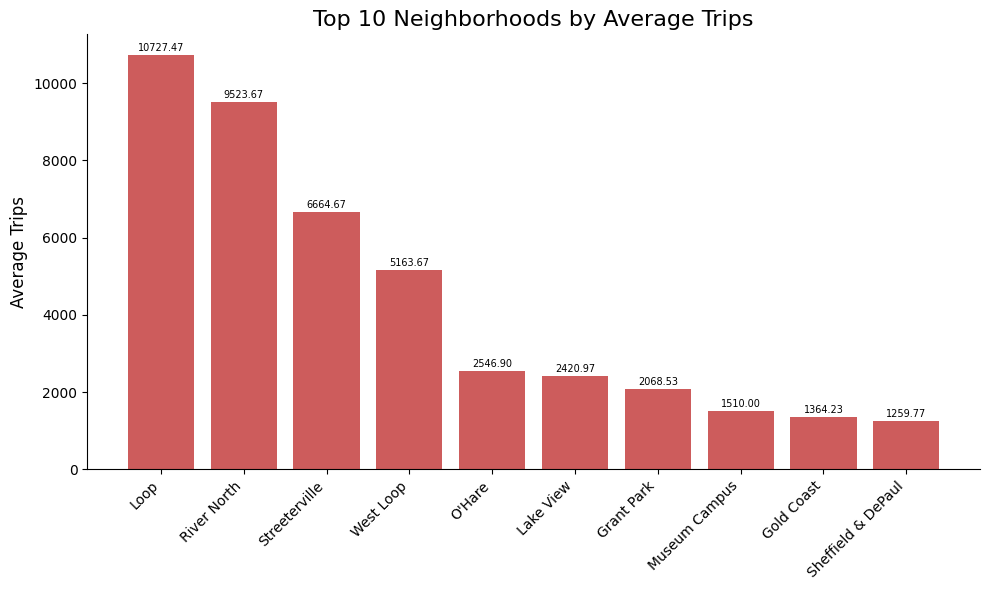

In [109]:
# Sort the DataFrame and select the top 10 neighborhoods
top_10_neighborhoods = trips_df.sort_values(by='average_trips', ascending=False).head(10)

# Plot the data
plt.figure(figsize=(10, 6))  # Set the figure size
bars = plt.bar(top_10_neighborhoods['dropoff'], top_10_neighborhoods['average_trips'], color='indianred')

# Add total values on top of the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,  # X position (center of the bar)
             bar.get_height() + 50,  # Y position (slightly above the bar)
             f'{bar.get_height():.2f}',  # Value to display
             ha='center', va='bottom', fontsize=7, color='black')  # Alignment and font size

# Titles and labels
plt.title('Top 10 Neighborhoods by Average Trips', fontsize=16)
plt.ylabel('Average Trips', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability

# Add a border
sns.despine()

# Show the plot
plt.tight_layout()
plt.show()

**Analysis of "Top 10 Neighborhoods by Average Trips":**

1. Loop leads the list with the highest average of trips: 10,727.47 trips.
2. River North is in second place with 9,523.67 trips.
3. Streeterville takes third place with 6,664.67 trips.
4. West Loop follows with 5,163.67 trips.
5. The area marked as "O'Hare" records 2,546.90 trips.
6. Lake View has an average of 2,420.97 trips.
7. Grant Park shows 2,068.53 trips.
8. Museum Campus records 1,510.00 trips.
9. Gold Coast has 1,364.23 trips.
10. Sheffield & DePaul closes the list with 1,259.77 trips.

**Conclusion:**
- There is a significant difference between the first four neighborhoods (Loop, River North, Streeterville, and West Loop) and the rest. This may indicate that most of the population or activities happen around these four neighborhoods.

---

### 4.1.1  Percentage of Trips by Neighborhood

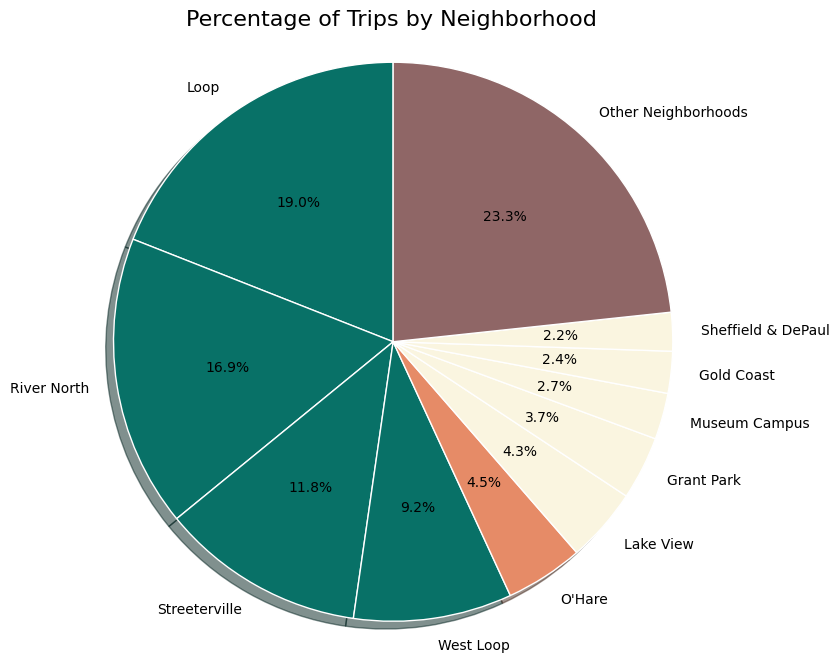

In [96]:
# Pie chart of percentage of trips by neighborhoods

# Total number of trips in the entire DataFrame
total_trips = trips_df['average_trips'].sum()

# Total number of trips in the top 10 neighborhoods
total_trips_top_10 = top_10_neighborhoods['average_trips'].sum()

# Filter out the rows where 'dropoff' is in the top 10 neighborhoods
other_neighborhoods = trips_df[~trips_df['dropoff'].isin(top_10_neighborhoods['dropoff'])]

# Calculate the total trips in the other neighborhoods (for pie chart use)
total_trips_other_neighborhoods = other_neighborhoods['average_trips'].sum()

# Create the data for the pie chart (10 slices for top 10 neighborhoods, 1 slice for other neighborhoods)
# Extract only the 'dropoff' neighborhoods in the top 10 for the labels
labels = list(top_10_neighborhoods['dropoff']) + ['Other Neighborhoods']

# Define colors for each slice
colors = ['#087167', '#087167', '#087167', '#087167', '#E68B67', 
          '#FAF5E0', '#FAF5E0', '#FAF5E0', '#FAF5E0', '#FAF5E0', '#8f6666']

# Get the 'average_trips' values for the top 10 and include the 'other_neighborhoods' total
sizes = list(top_10_neighborhoods['average_trips']) + [total_trips_other_neighborhoods]

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, shadow=True, 
        colors=colors, wedgeprops={'edgecolor': 'white', 'linewidth': 1})
plt.title('Percentage of Trips by Neighborhood', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()

**Analysis of 'Percentage of Trips by Neighborhood':**

**High Mobility Areas (Green):**
- **Loop:** 19.0% (the neighborhood with the highest percentage)
- **River North:** 16.9%
- **Streeterville:** 11.8%
- **West Loop:** 9.2%

These dark green areas represent the most traveled neighborhoods, making up approximately **57%** of all trips.

**Intermediate Areas (Orange):**
- **O'Hare:** 4.5%
- **Lake View:** 4.3%

The coral-colored areas represent neighborhoods with moderate traffic, totaling around **9%** of the trips.

**Low Mobility Areas (Beige):**
- **Grant Park:** 3.7%
- **Museum Campus:** 2.7%
- **Gold Coast:** 2.4%
- **Sheffield & DePaul:** 2.2%

These light-colored areas represent neighborhoods with lower traffic, summing up to approximately **11%** of the trips.

**Other Neighborhoods (Coffee):**
This section represents all other neighborhoods in the city that are not among the main ones but together make up nearly a quarter of the total trips, with **23.3%**.

**Conclusion:**
- It is notable that the green areas clearly dominate the chart, representing **more than half** of all trips.

---


## 4.2 Top 10 Taxi Companies 

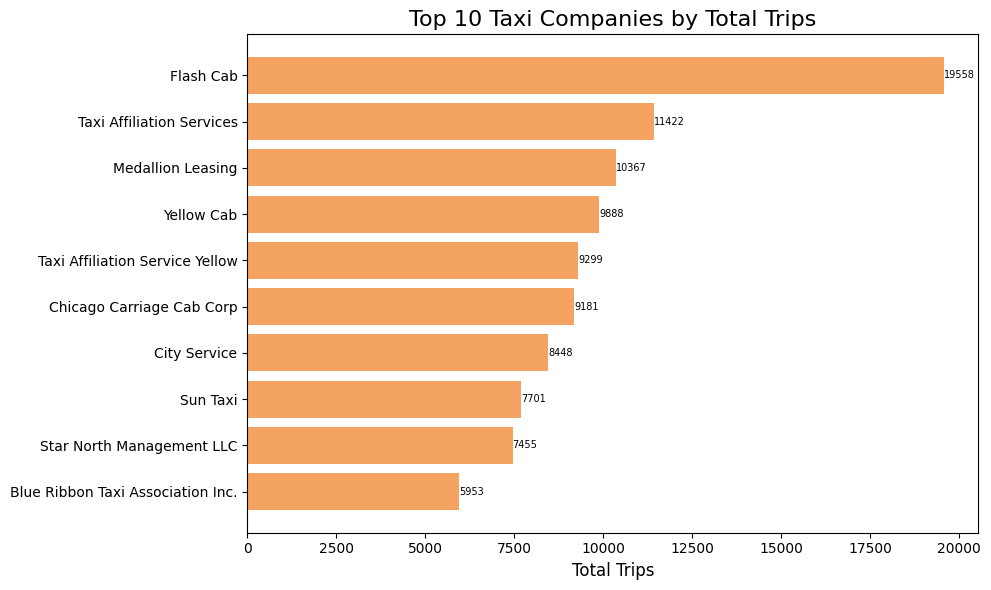

In [108]:
# Group companies, sum trips, and sort by trips_amount
top_10_companies = (
    company_df.groupby('company_name', as_index=False)['trips_amount']
    .sum()
    .sort_values(by='trips_amount', ascending=False)
    .head(10)  # Get the top 10 companies
)

# Create a horizontal bar chart for the top 10 taxi companies
plt.figure(figsize=(10, 6))
plt.barh(top_10_companies['company_name'], top_10_companies['trips_amount'], color='sandybrown')

# Add titles and labels
plt.title('Top 10 Taxi Companies by Total Trips', fontsize=16)
plt.xlabel('Total Trips', fontsize=12)
plt.gca().invert_yaxis()  # Invert the y-axis to show the highest value at the top 

# Add value annotations to the bars (gray color and font size 7)
for index, value in enumerate(top_10_companies['trips_amount']):
    plt.text(value, index, str(value), va='center', ha='left', color='black', fontsize=7)

# Show the chart
plt.tight_layout()
plt.show()

**Analysis of 'Top 10 Taxi Companies by Total Trips':**

**Company Rankings:**

1. **Flash Cab**: 19,558 trips.  
   - Undisputed market leader.  
   - Surpasses the second place by more than 8,000 trips.  

2. **Taxi Affiliation Services**: 11,422 trips.  
3. **Medallion Leasing**: 10,367 trips.  
4. **Yellow Cab**: 9,888 trips.  
5. **Taxi Affiliation Service Yellow**: 9,299 trips.  
6. **Chicago Carriage Cab Corp**: 9,181 trips.  
7. **City Service**: 8,448 trips.  
8. **Sun Taxi**: 7,701 trips.  
9. **Star North Management LLC**: 7,455 trips.  
10. **Blue Ribbon Taxi Association Inc.**: 5,953 trips.  

**OBSERVATIONS:**
- There is a large gap between first place (Flash Cab) and the other competitors.  
- The top three companies account for a significant portion of the total trips.  
- The difference between positions 4-8 is relatively small, showing a competitive market in this segment.  

- There is a clear division into three levels:  
  * **Top Level**: Flash Cab.  
  * **Middle Level**: Positions 2-7.  
  * **Bottom Level**: Last three positions.  
  
  ---

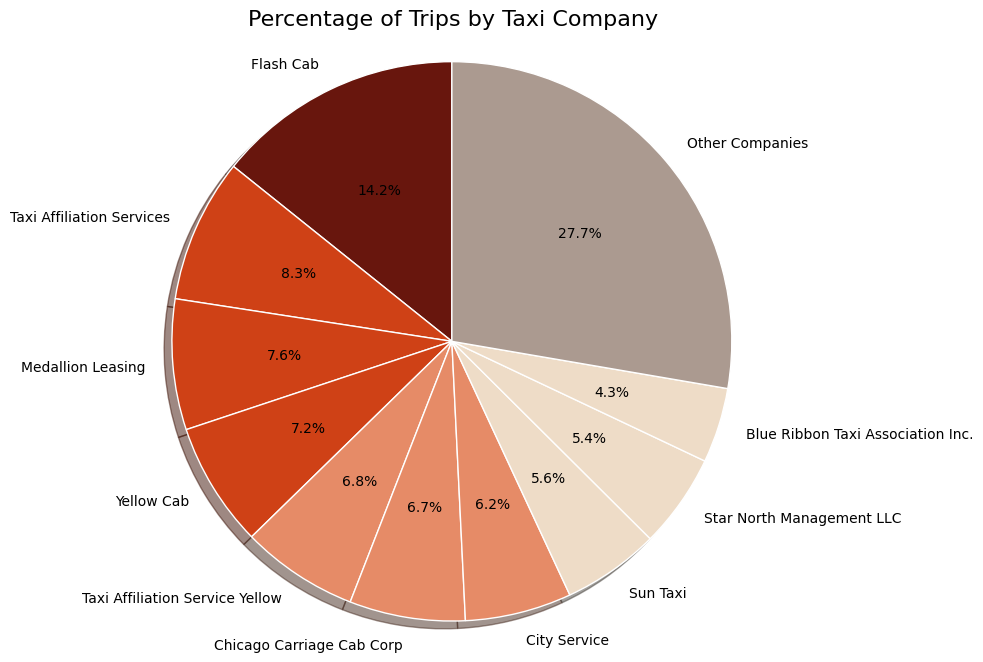


Percentage of trips for the top 10 companies: 72.3
Percentage of trips for other companies: 27.7


In [98]:
# Total number of trips in the entire DataFrame
total_trips = company_df['trips_amount'].sum()

# Top 10 companies by trips
top_10_companies = (
    company_df.groupby('company_name', as_index=False)['trips_amount']
    .sum()
    .sort_values(by='trips_amount', ascending=False)
    .head(10)
)

# Calculate the total trips for companies outside the top 10
other_companies = total_trips - top_10_companies['trips_amount'].sum()

# Create labels and sizes for the pie chart
labels = list(top_10_companies['company_name']) + ['Other Companies']
sizes = list(top_10_companies['trips_amount']) + [other_companies]

# Define colors for the chart
colors = [
    '#68160D', '#CF4116', '#CF4116', '#CF4116',
    '#E68B67', '#E68B67', '#E68B67', '#EEDCC7',
    '#EEDCC7', '#EEDCC7', '#AB9A90'
]

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    shadow=True,
    colors=colors,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1}
)
plt.title('Percentage of Trips by Taxi Company', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()

# Calculate the percentage of trips for the top 10 companies
top_10_total_trips = round((top_10_companies['trips_amount'].sum() / total_trips) * 100, 2)

# Calculate the percentage of trips for other companies
other_companies = round(((total_trips - top_10_companies['trips_amount'].sum()) / total_trips) * 100, 2)

# Print the results
print("\nPercentage of trips for the top 10 companies:", top_10_total_trips)
print("Percentage of trips for other companies:", other_companies)

**Analysis of 'Percentage of Trips by Taxi Company':**

**Market Leader (Coffee Company):**
- **Flash Cab**: 14.2%  
This is the market leader with the highest individual percentage, while the others compete for second place.

**Main Companies (Orange):**
- **Taxi Affiliation Services**: 8.3%
- **Medallion Leasing**: 7.6%
- **Yellow Cab**: 7.2%  
These companies represent the second level of importance, together accounting for 23.1% of the market.

**Medium Companies (Coral):**
- **Taxi Affiliation Service Yellow**: 6.8%
- **Chicago Carriage Cab Corp**: 6.7%
- **City Service**: 6.2%  
This group represents medium-sized companies, making up 19.7% of the market.

**Smaller Companies (Beige):**
- **Sun Taxi**: 5.6%
- **Star North Management LLC**: 5.4%
- **Blue Ribbon Taxi Association Inc.**: 4.3%  
The smaller companies in the top 10 make up 15.3% of the market.

**Other Companies (Gray):**
- **Other Companies**: 27.7%  
This represents all other taxi companies not in the top 10, but together they form over a quarter of the total market.

**OBSERVATIONS:**
- The market is quite fragmented, with no single company dominating completely.
- **Other Companies** have the largest individual share of the market (27.7%).
- **Flash Cab** stands out as the individual leader but with only 14.2%.
- There is a relatively equitable distribution among the top 10 companies (except for **Flash Cab**).

---

#  5.  Hypothesis testing 

- **Null Hypothesis (H₀)**: The average duration of trips from the Loop to O'Hare International Airport changes on rainy Saturdays.

- **Alternative Hypothesis (H₁)**: The average duration of trips from the Loop to O'Hare International Airport does not change significantly on rainy Saturdays.

---

In [99]:
# Filter the data for rainy (Bad) and non-rainy (Good) days
bad_weather_df = ohare_df[(ohare_df['weather_conditions'] == 'Bad')] 
good_weather_df = ohare_df[(ohare_df['weather_conditions'] == 'Good')]

# Travel durations in minutes
bad_weather_durations = bad_weather_df['duration_minutes']
good_weather_durations = good_weather_df['duration_minutes']

# Perform a Student's t-test to compare the mean durations
t_stat, p_value = stats.ttest_ind(bad_weather_durations, good_weather_durations)

# Show the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpret the p-value
alpha = 0.05  # Significance level
if p_value < alpha:
    print("Reject the null hypothesis (H₀): The average duration changes on rainy Saturdays.")
else:
    print("Fail to reject the null hypothesis (H₀): The average duration does not change significantly on rainy Saturdays.")


T-statistic: 5.226515952009484
P-value: 2.1676542453689916e-07
Reject the null hypothesis (H₀): The average duration changes on rainy Saturdays.


**Let's explore in relation to the results of the hypothesis**

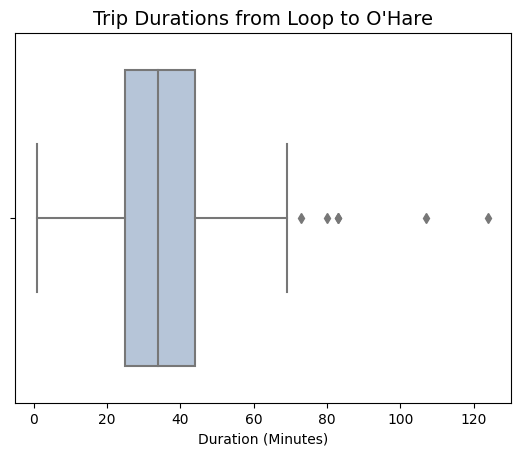

In [103]:
# Create a boxplot for the trip durations in minutes
sns.boxplot(x=ohare_df['duration_minutes'], color='lightsteelblue')
plt.title('Trip Durations from Loop to O\'Hare', fontsize=14)
plt.xlabel('Duration (Minutes)')
plt.show()   

**Analysis of 'Trip Durations from Loop to O'Hare':**
- **Central Box**: Represents 50% of the data (between 20-40 minutes).
- **Line inside the box**: Median (approximately 30 minutes).
- **Outliers**: Represent exceptionally long trips, ranging from 70 to 120 minutes.
- **Main Concentration**: 20-40 minutes.
- **Median**: ~30 minutes.
- **Skewness**: Slightly positive (tail towards the right).
- **Dispersion**: Moderate within the normal range.

---

In [101]:
# Bad/Good Weather Days data
bad_weather_stats = bad_weather_df['duration_minutes'].describe()
good_weather_stats = good_weather_df['duration_minutes'].describe()

# Statistics

print("Statistics for Bad Weather Days:")
print(f"Count: {bad_weather_stats['count']:.0f}")
print(f"Mean: {bad_weather_stats['mean']:.2f}")
print(f"Std Dev: {bad_weather_stats['std']:.2f}")
print(f"Min: {bad_weather_stats['min']:.2f}")
print(f"Max: {bad_weather_stats['max']:.2f}")

print("\nStatistics for Good Weather Days:")
print(f"Count: {good_weather_stats['count']:.0f}")
print(f"Mean: {good_weather_stats['mean']:.2f}")
print(f"Std Dev: {good_weather_stats['std']:.2f}")
print(f"Min: {good_weather_stats['min']:.2f}")
print(f"Max: {good_weather_stats['max']:.2f}")


Statistics for Bad Weather Days:
Count: 148
Mean: 40.36
Std Dev: 12.51
Min: 8.00
Max: 83.00

Statistics for Good Weather Days:
Count: 717
Mean: 34.45
Std Dev: 12.55
Min: 1.00
Max: 124.00


**Bad Weather Days**:
- **Total trips**: 148 trips
- **Average duration**: 40.63 minutes
- **Standard deviation**: 12.51 minutes (indicating moderate variation)
- **Shortest trip**: 8 minutes
- **Longest trip**: 83 minutes

**Good Weather Days**:
- **Total trips**: 723 trips
- **Average duration**: 34.16 minutes
- **Standard deviation**: 12.88 minutes (slightly higher variation than on bad weather days)
- **Shortest trip**: 1 minute (likely canceled trips)
- **Longest trip**: 124 minutes

**Conclusion**: The average trip duration on bad weather days is longer (40.63 minutes) than on good weather days (33.57 minutes). However, there is more variation in trip durations on good weather days, with some trips being very short or very long.

---

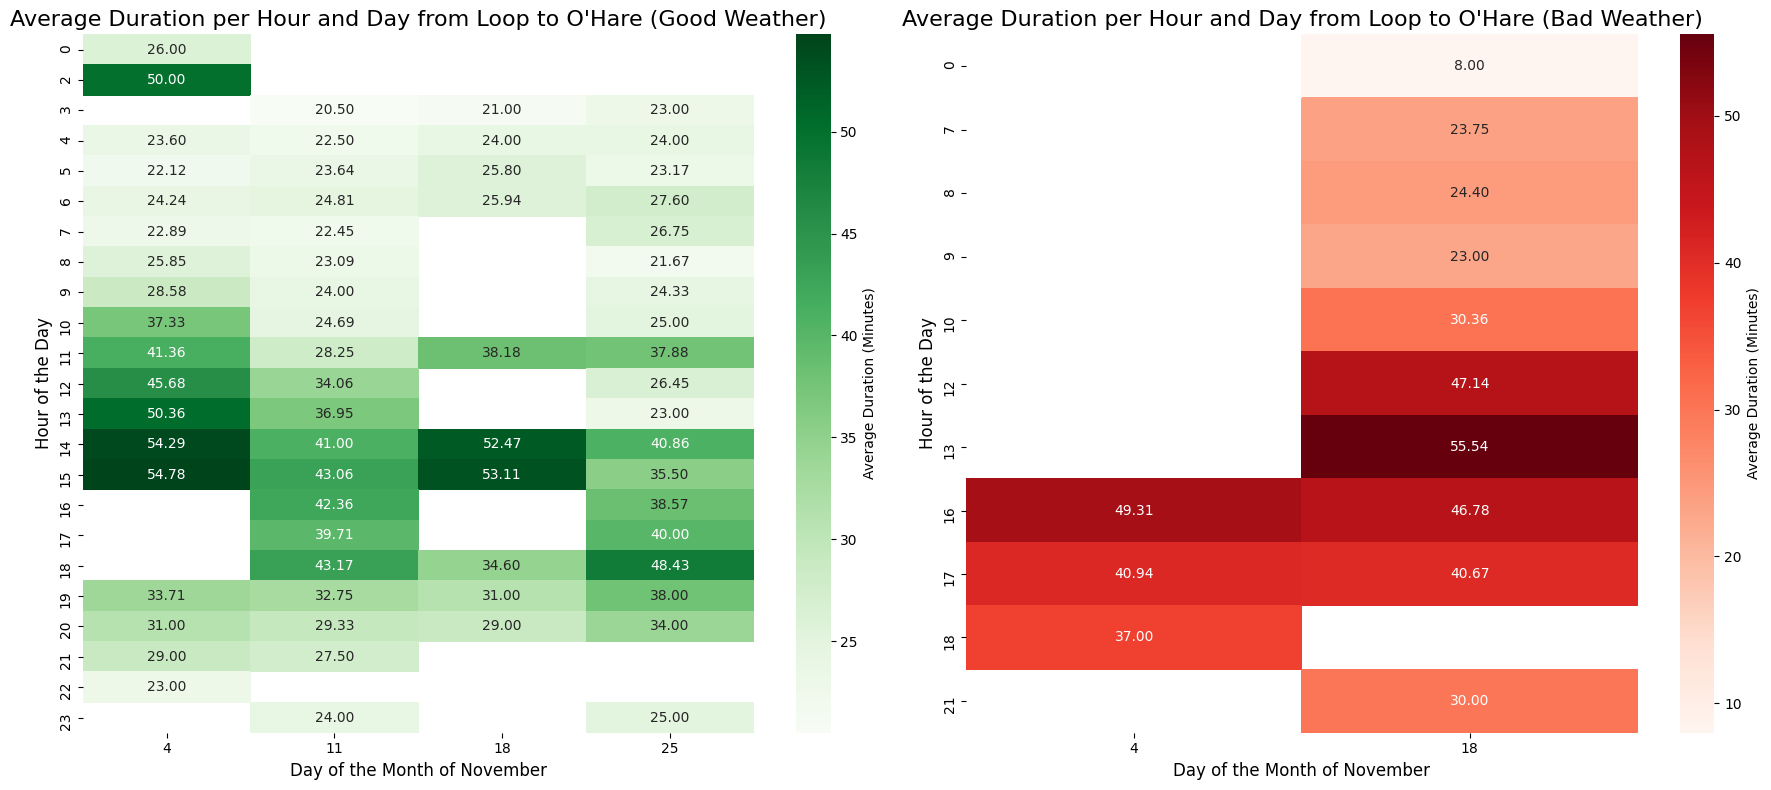

In [102]:
# Create a pivot table for "Good" weather conditions with average duration in minutes
heatmap_data_good = good_weather_df.pivot_table(
    index='hour',    
    columns='day',    
    values='duration_minutes', 
    aggfunc='mean',    
)

# Create a pivot table for "Bad" weather conditions with average duration in minutes
heatmap_data_bad = bad_weather_df.pivot_table(
    index='hour',    
    columns='day',    
    values='duration_minutes', 
    aggfunc='mean',   
)

# Create subplots to display heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot the heatmap for "Good" weather on the first subplot
sns.heatmap(heatmap_data_good, cmap='Greens', annot=True, fmt='.2f', cbar_kws={'label': 'Average Duration (Minutes)'}, ax=axes[0])
axes[0].set_title('Average Duration per Hour and Day from Loop to O\'Hare (Good Weather)', fontsize=16)
axes[0].set_xlabel('Day of the Month of November', fontsize=12)
axes[0].set_ylabel('Hour of the Day', fontsize=12)


# Plot the heatmap for "Bad" weather on the second subplot
sns.heatmap(heatmap_data_bad, cmap='Reds', annot=True, fmt='.2f', cbar_kws={'label': 'Average Duration (Minutes)'}, ax=axes[1])
axes[1].set_title('Average Duration per Hour and Day from Loop to O\'Hare (Bad Weather)', fontsize=16)
axes[1].set_xlabel('Day of the Month of November', fontsize=12)
axes[1].set_ylabel('Hour of the Day', fontsize=12)


# Adjust layout
plt.tight_layout()
plt.show()

**Analysis of 'Average Trip Duration from Loop to O'Hare**':

**Good Weather**:
   - The longest trips (dark green) occur between 1:00 PM and 3:00 PM.
   - The maximum duration is 54.78 minutes around 3:00 PM.
   - The second longest duration occurs at 2:00 PM, with 54.29 minutes.

**Bad Weather**:
   - The maximum duration occurs at 1:00 PM, with 55.54 minutes.
   - High durations are observed between 12:00 PM and 4:00 PM (dark red).
   - Significant increases in trip duration are noted compared to good weather conditions.
   
 ---

# 6. Insights and Recommendations

## 6.1 High Demand Areas and Leading Companies

**Loop and River North**:
   - These are business and entertainment hubs, so taxi demand is constant. The leading taxi company in these areas holds the largest market share, dominating the competition in these zones.

**Streeterville and West Loop**:
   - These are residential and commercial areas with high activity. Companies ranking in the top positions have a strong presence, especially during peak hours.

**O'Hare**:
   - As an airport, taxi demand is very high, especially for travelers. The leading company also dominates this area due to the high turnover of passengers.


## 6.2 The Top 4 Companies

   - **Flash Cab** (19,558 trips): Undisputed market leader, with more than 8,000 trips ahead of second place.
   - **Taxi Affiliation Services** (11,422 trips): Second in the ranking, with a notable market presence.
   - **Medallion Leasing** (10,367 trips): Third in the ranking, showing a solid market share.
   - **Yellow Cab** (9,888 trips): Fourth in the ranking, with a competitive number of trips.

The **top 4 companies** clearly dominate the market, with **Flash Cab** leading by a large margin. Companies in **second, third, and fourth place** are closely competing for second place, while the leader maintains a very strong and hard-to-surpass position.

**Recommendations for Competing**:

- **Increase the number of taxis in key zones** to cover high demand, especially in **Loop** and **O'Hare**.
- **Offer promotions or discounts** to attract more passengers and compete with leading companies.
- **Optimize routes and wait times** using tools that analyze when and where demand is highest.

These actions will help compete with the top companies and improve service in high-demand areas.



## 6.3 Trips Are Generally Longer Due to Bad Weather

**Differences in Bad Weather**:
   - Bad weather increases travel times at almost all hours, with an average difference of 5-10 minutes more.
   - Peak hour patterns remain similar in both conditions, with afternoon trips generally taking longer to reach O'Hare Airport.
- Most trips last between 20-40 minutes.
- Trips over 65 minutes are considered outliers.
- It is very rare to find trips exceeding 120 minutes.
- Recommended plan: consider 40 minutes + extra time depending on weather conditions.

This information is valuable for planning trips to the airport, suggesting that both the time of day and weather conditions should be considered when scheduling a trip from Loop to O'Hare. This leads to the following recommendations.

**Recommendations Based on the Analysis**:
- It is recommended to add an extra 10-15 minutes to the estimated trip time, and to send an alert through the app to people in the Loop area if it starts raining, explaining that if the destination is the airport, they should request the trip at least 10 minutes earlier than planned.


## 6.4  Summary
- Plan trips with greater anticipation and ensure the availability of vehicles in high-traffic areas.
- Implement discounts and promotional codes.
- Consider alternative routes.

--- 